# Freq / Rec Analysis & CLV Calculation in Non-Contractual Business

This notebook is more or less following the quickstart docs of the [Lifetimes](https://github.com/CamDavidsonPilon/lifetimes) package developed by Cameron Davidson-Pilon, but using different data.

After having gone to the first two notebooks, the most interesting part is Frequency / Recency Analysis and especially the calculation of P(Alive) for individual customers, where I have tried to document the assumptions and shortcomings of the BG / NBD model. To be honest I can't fully understand / interpret the results.

## Content

#### 1. Prepare Data
- Assess Data, 
- Clean Data to bring it into the right format for the specific transformation
- Transform with help of lifetimes

#### 2. Basic Frequency / Recency Analysis Using the BG / NBD Model
- Frequency / Recency Matrix
- Probability Alive Matrix
- Individual Customer Predictions (number of transactions in next period(s))
- Customer History Plots (OPEN ISSUE, see [here](https://github.com/CamDavidsonPilon/lifetimes/issues/231))
- Calculation P(Alive) for individual customers **_(conceptual ISSUE, documented)_**
- Assess Model Fit
- Fit Model with Holdout Set (Best practice, should better be done this way than the initial way)

#### 3. Estimate customer lifetime value using the Gamma-Gamma model
- Check independence assumption
- Estimate CLV
- Estimate average transactions

---

### Import libraries, load data

In [1]:
# import libraries
import numpy as np
import pandas as pd
import datetime as dt

from lifetimes.plotting import *
from lifetimes.utils import *
from lifetimes.estimation import *


from lifetimes import BetaGeoFitter

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(), sns.set_style('whitegrid')
%matplotlib inline  

# special settings for lifetime plots
sns.set_palette("viridis")
sns.set(rc={'image.cmap': 'viridis'})

import cleaning_functions as clean
import EDA_functions as EDA

# display of all columns in df - check if pd option below isn't better
from IPython.display import display
pd.options.display.max_columns = None

In [2]:
# load data
data = pd.read_excel("data/raw/OnlineRetail.xlsx")

## 1) Prepare Data

### Assess Data

In [3]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
# change dtype for customerID to object
clv_data = clean.change_dtypes(data.copy(), cols_to_object=['CustomerID'])

# normalize InvoiceDate to dates (remove time)
clv_data['InvoiceDate'] = clv_data['InvoiceDate'].dt.date

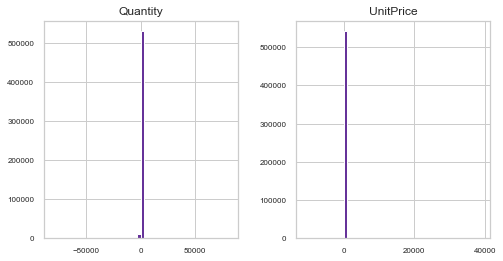

In [6]:
# check distribution of numerical data
EDA.plot_num_hist(clv_data, figsize=(8,4))

In [7]:
# check characteristics of numeric data
clv_data.describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


In [8]:
print("neg Quantities: ", len(clv_data.loc[clv_data['Quantity'] <= 0]))
print("neg unitPrices: ", len(clv_data.loc[clv_data['UnitPrice'] <= 0]))

neg Quantities:  10624
neg unitPrices:  2517


In [9]:
# check characteristics of object data
clv_data.describe(include = 'object')

,InvoiceNo,StockCode,Description,InvoiceDate,CustomerID,Country
count,541909,541909,540455,541909,541909,541909
unique,25900,4070,4223,305,4373,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2011-12-05,nan,United Kingdom
freq,1114,2313,2369,5331,135080,495478


**Note:** For Lifetimes we need an Input Dataframe of transaction data of the form: 
- customer_id
- datetime 
- [monetary_value] (optional, needed for clv estimations only)



**Need for cleaning:**
- drop orders with quantities <= 0
- drop orders with unit_price <= 0
- drop orders with missing customer ID
- add new column sales (quant * price)
- change ID to dtype str
- drop cols we won't need no more: InvoiceNo, Description, Country, StockCode, Quantity, Price

### Clean & Transform Data

In [10]:
"""clean according to list"""

clv_data = clv_data.loc[clv_data['CustomerID'] != 'nan']
clv_data = clv_data.loc[clv_data['Quantity'] > 0]
clv_data = clv_data.loc[clv_data['UnitPrice'] > 0]
clv_data['CustomerID'] = clv_data['CustomerID'].astype(str).str.split('.').str.get(0)
clv_data['Sales'] = clv_data['Quantity'] * clv_data['UnitPrice']
clv_data.drop(['InvoiceNo', 'StockCode', 'Quantity', 'UnitPrice', 
    'Description', 'Country'], inplace=True, axis=1)

assert clv_data.isnull().sum().sum() == 0, "NaN in the Set"

In [11]:
# check results
print(clv_data.shape)
display(clv_data.head())

(397884, 3)


,InvoiceDate,CustomerID,Sales
0,2010-12-01,17850,15.30
1,2010-12-01,17850,20.34
2,2010-12-01,17850,22.00
3,2010-12-01,17850,20.34
4,2010-12-01,17850,20.34


In [12]:
"""transform dataframe"""

clv = summary_data_from_transaction_data(clv_data, 'CustomerID', 'InvoiceDate', monetary_value_col='Sales')
# check results
print(clv.shape)
clv.head()

(4338, 4)


,frequency,recency,T,monetary_value
CustomerID,,,,
12346,0.0,0.0,325.0,0.000000
12347,6.0,365.0,367.0,599.701667
12348,3.0,283.0,358.0,301.480000
12349,0.0,0.0,18.0,0.000000
12350,0.0,0.0,310.0,0.000000


**Nomenclature for the CLV model:**

- _Frequency_: represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases. (Thus if they have made only 1 purchase, the recency is 0.)
- _T_: represents the age of the customer in whatever time units chosen (daily, in our dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.
- _Recency_: represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)

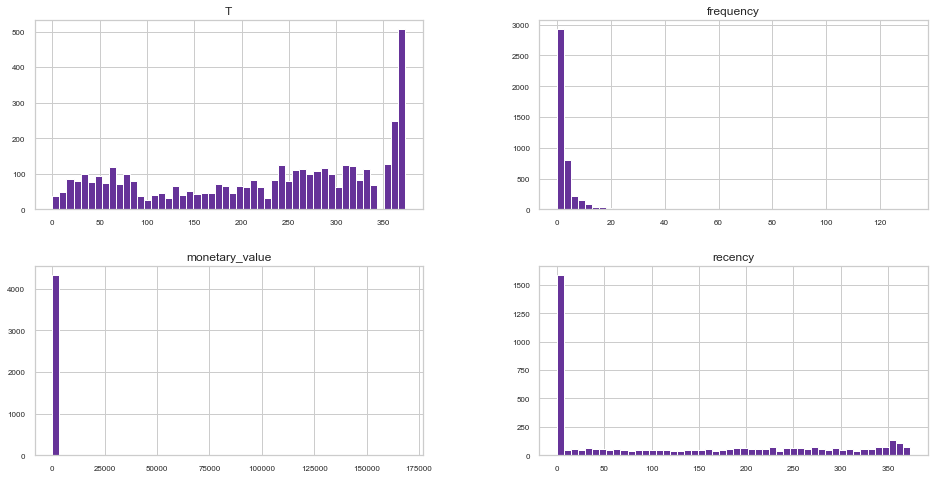

In [13]:
"""assess data"""

EDA.plot_num_hist(clv, figsize=(16,8))

In [14]:
print("prop of customers without repeat purchase: ", round(clv['frequency'].value_counts()[0]/len(clv),3))

prop of customers without repeat purchase:  0.357


## 2. Basic Frequency / Recency Analysis Using the BG / NBD Model

In [15]:
"""fit BG model""" # note: similar API to scikit-learn and lifelines.

bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(clv['frequency'], clv['recency'], clv['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 4338 subjects, a: 0.00, alpha: 68.90, b: 5.90, r: 0.83>


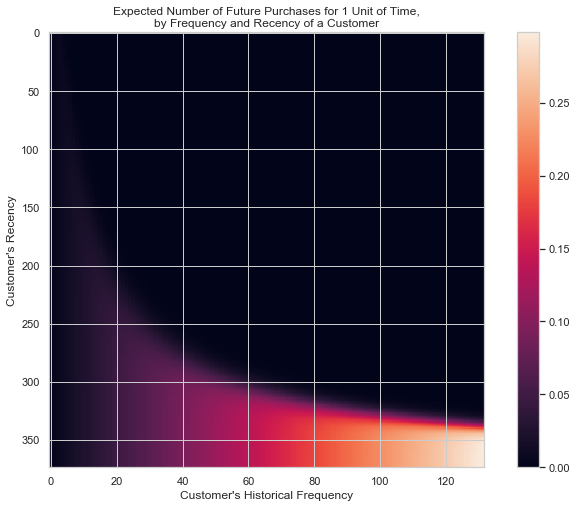

In [16]:
# plot frequency_recency_matrix
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf);

**Explanation:** Consider a customer bought from you every day for three weeks straight, and we haven’t heard from them in months. What are the chances they are still “alive”? Pretty small. On the other hand, a customer who historically buys from you once a quarter, and bought last quarter, is likely still alive. We can visualize this relationship using the Frequency/Recency matrix, which computes the expected number of transactions a artificial customer is to make in the next time period, given his or her recency (age at last purchase) and frequency (the number of repeat transactions he or she has made).

- Our best customer is one that has made 250 purchases, and his latest purchase was when he was approximately 350 days old (bottom-right). Customers who have purchased a lot and purchased recently will likely be the best customers in the future. 
- Customers who have purchased a lot in the past but we have not heard them for long are the 'coldest', they have probably churned away (top-right corner).
- There’s also that beautiful “tail” around (20, 250). That represents the customer who buys infrequently, but we’ve seen him or her recently, so they might buy again - we’re not sure if they are dead or just between purchases.

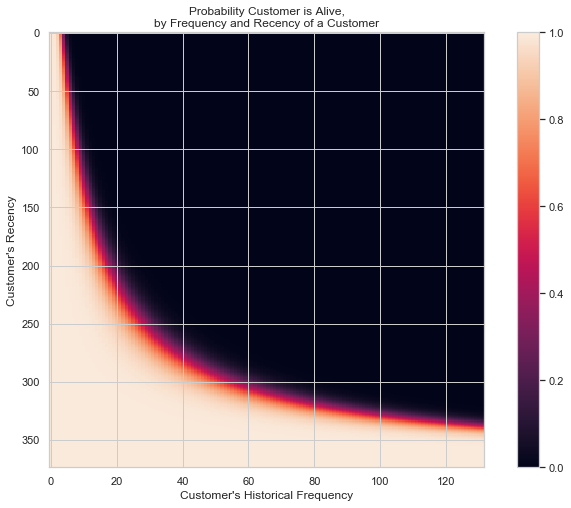

In [17]:
# plot probability_alive_matrix
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf);

(**Technical Details:** The plot_probability_alive_matrix function computes P(alive) for all theoretical combinations of recency and frequency up to the maxima in your datasets given the parameters computed during the fit step. It assumes customer age, T, to be equal to the maximum age of customers in the dataset.)

### Ranking customers from best to worst

Let’s rank our customers them from “highest expected purchases in the next period” to lowest. Models expose a method that will predict a customer’s expected purchases in the next period using their history.

In [18]:
t = 1  # setting number of periods for prediction
clv['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, 
    clv['frequency'], clv['recency'], clv['T'])

#check results
clv.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
14606,88.0,372.0,373.0,135.890114,0.201000
15311,89.0,373.0,373.0,677.729438,0.203264
17841,111.0,372.0,373.0,364.452162,0.253047
12748,112.0,373.0,373.0,301.024821,0.255312
14911,131.0,372.0,373.0,1093.661679,0.298305


### Individual Customer Predictions
Based on customer history, we can predict what an individuals future purchases might look like.

In [19]:
t = 10 # predict purchases in 10 periods
individual = clv.loc['12347']
# The below function is an alias to `bfg.conditional_expected_number_of_purchases_up_to_time`
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

0.15655633395146978

### Individual Customer Probability Histories

Given a customer transaction history, we can calculate their historical probability of being alive, according to our trained model.

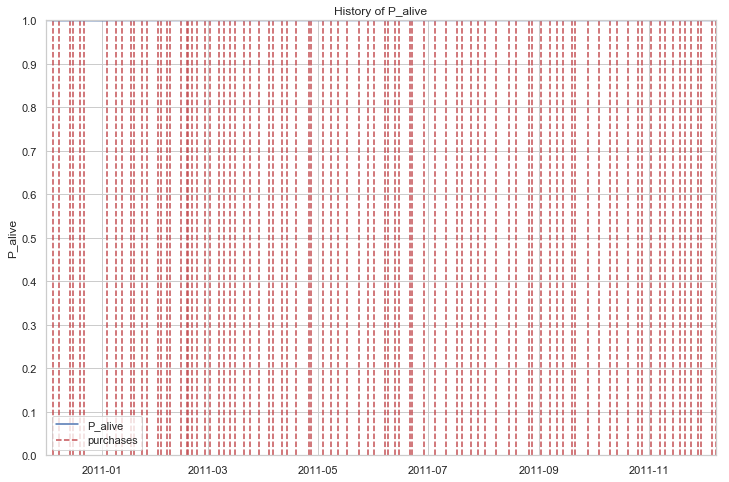

In [20]:
fig = plt.figure(figsize=(12,8))
id = '14606'
days_since_birth = 365
sp_trans = clv_data.loc[clv_data['CustomerID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate');

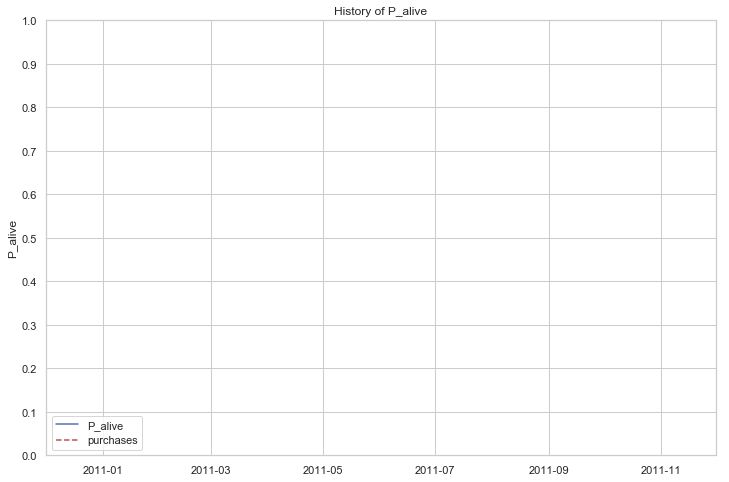

In [21]:
fig = plt.figure(figsize=(12,8))
id = '14729'
days_since_birth = 365
sp_trans = clv_data.loc[clv_data['CustomerID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate');

### _Issue: Calculating P(alive) - unsolved_

If we calculate P(alive) with the bgf model, the probability score defaults to 1 for users that have no frequency (one-time purchasers). The Bruce Hardie paper that can be found in the `resources` states: _"We note that P(alive) = 1 for a customer who made no purchases in the interval (0, T]; this follows from the model’s assumptions that death occurs after a purchase and that customers are alive at the beginning of the observation period._

class BetaGeoFitter(). This model has the following assumptions:
1. Each individual, `i`, has a hidden `lambda_i` and `p_i` parameter
2. These come from a population wide Gamma and a Beta distribution respectively.
3. Individuals purchases follow a Poisson process with rate `lambda_i*t` .
4. After each purchase, an individual has a p_i probability of dieing (never buying again).

min: 0.72, max 1.0


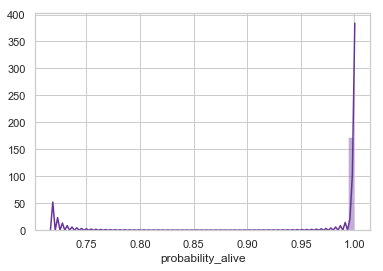

In [22]:
"""calculate the probabilities P(alive) for the customers"""

clv["probability_alive"] = bgf.conditional_probability_alive(clv["frequency"], 
                                                             clv ["recency"], clv ["T"])

# check results
print("min: {}, max {}".format(round(np.min(clv["probability_alive"]),2), \
np.max(clv["probability_alive"])))
sns.distplot(clv['probability_alive'], color='rebeccapurple');

Statement Cameron concerning this [issue](https://github.com/CamDavidsonPilon/lifetimes/issues/235): Agree. Part of the problem, I suspect, is that you are using a model that doesn't allow many deaths! If you are using the BG/NBD model, take a look at the "customer story" again. Remember that deaths can only happen after a purchase event, and if a customer only makes 1 purchase every ~15months, then that's a very low chance of dying each month. Does that make sense?
Generally, I'm now advocating for the BG/BB model instead of the BG/NBD model because of the internal paradox in the BG/NBD "customer story".

**Not really working solution**

The [Modified Beta-Geometric model](https://github.com/CamDavidsonPilon/lifetimes/blob/master/lifetimes/fitters/modified_beta_geo_fitter.py) should help. Details again in the paper and the issue [here](https://github.com/CamDavidsonPilon/lifetimes/issues/165). But it doesn't, at least without tuning.

class ModifiedBetaGeoFitter(BetaGeoFitter). This model has the following assumptions:
1. Each individual, ``i``, has a hidden ``lambda_i`` and ``p_i`` parameter
2. These come from a population wide Gamma and a Beta distribution respectively.
3. Individuals purchases follow a Poisson process with rate `\lambda_i*t` .
4. _At the beginning of their lifetime_ and after each purchase, an individual has a p_i probability of dieing (never buying again).

In [23]:
"""fit MBG model""" # note: similar API to scikit-learn and lifelines.

mbgf = ModifiedBetaGeoFitter(penalizer_coef=0.0)
mbgf.fit(clv['frequency'], clv['recency'], clv['T'])
print(mbgf)

<lifetimes.ModifiedBetaGeoFitter: fitted with 4338 subjects, a: 0.00, alpha: 79.90, b: 4.45, r: 0.96>


min: 1.0, max 0.9999999022993571


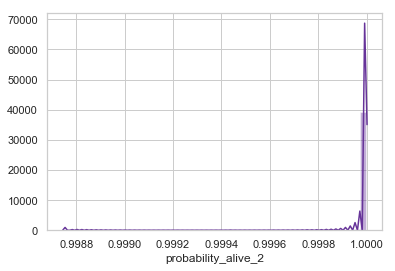

In [24]:
"""calculate the probabilities P(alive) for the customers"""

clv["probability_alive_2"] = mbgf.conditional_probability_alive(clv["frequency"], 
                                                             clv ["recency"], clv ["T"])

# check results
print("min: {}, max {}".format(round(np.min(clv["probability_alive_2"]),2), \
np.max(clv["probability_alive_2"])))
sns.distplot(clv['probability_alive_2'], color='rebeccapurple');

**My main concern:** I can understand that one-timers have a probability of 1 / high probability of alive due to the model design. But why are there no customers with P(alive) < 0.8 resp. 0.9??? I don't get that.

(The one timers could maybe be handled manually with the average inter-purchase time as a baseline for assuming the first-time customers' probability of being alive ...)

---

### Assess model fit

There are a few ways to assess the model’s correctness. The first is to compare your data versus artificial data simulated with your fitted model’s parameters. We can see that our actual data and our simulated data line up well. This proves that our model doesn’t suck.

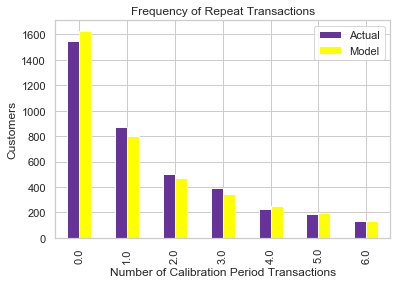

In [25]:
plot_period_transactions(bgf, color=['rebeccapurple', 'yellow']);

### Fit model with holdout set

With transactional data, we can partition the dataset into a calibration period dataset and a holdout dataset. This is important as we want to test how our model performs on data not yet seen (think cross-validation in standard machine learning literature). Lifetimes has a function to partition our dataset like this:

In [26]:
"""fit model with calibration and holdout sets"""

summary_cal_holdout = calibration_and_holdout_data(clv_data, 'CustomerID', 'InvoiceDate', 
                                                   monetary_value_col='Sales',
                                                   calibration_period_end='2011-06-08',
                                                   observation_period_end='2011-12-9')   

In [30]:
# check results
display(summary_cal_holdout.head())

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
CustomerID,,,,,,,
12346,0.0,0.0,141.0,0.00,0.0,0.000000,<184 * Days>
12347,2.0,121.0,183.0,555.82,4.0,25.373163,<184 * Days>
12348,2.0,110.0,174.0,297.22,1.0,103.333333,<184 * Days>
12350,0.0,0.0,126.0,0.00,0.0,0.000000,<184 * Days>
12352,3.0,34.0,112.0,421.77,3.0,20.090000,<184 * Days>


In [32]:
# 'Repair' duration_holdout: set to float - should not happen according to docs ...
import re
summary_cal_holdout['duration_holdout'] = \
    summary_cal_holdout['duration_holdout'].astype(str)    
summary_cal_holdout['duration_holdout'] = \
    summary_cal_holdout['duration_holdout'].apply(lambda x: int(re.findall('\d+', x)[0]))

In [33]:
"""fit on the _cal columns, and test on the _holdout columns"""

bgf.fit(summary_cal_holdout['frequency_cal'], 
        summary_cal_holdout['recency_cal'], 
        summary_cal_holdout['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 2787 subjects, a: 0.00, alpha: 61.78, b: 12.31, r: 0.74>

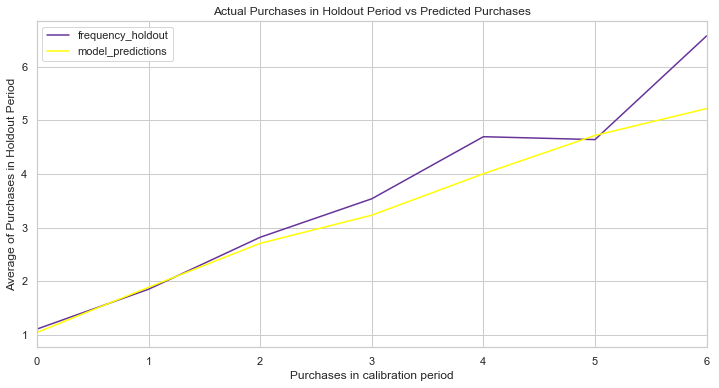

In [34]:
# plot results
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout, figsize=(12,6),
                                                color=['rebeccapurple', 'yellow']);

---

## 3) Estimate customer lifetime value using the Gamma-Gamma model
To estimate the CLV we use the [Gamma-Gamma submodel presented by Dr. Peter Fader and Dr. Bruce Hardie from Wharton](http://www.brucehardie.com/notes/025/gamma_gamma.pdf). It can be seen as an extension to the BG/NBD, whichfocuses on modeling purchase count. Gamma-Gamma makes a few assumptions:
* At the customer level, the transaction/order value varies randomly around each customer’s average transaction value. (That, in itself, isn’t too controversial, but has to be checked, see below.)
* The observed mean value is an imperfect metric of the latent mean transaction value E(M), where M represents the monetary value.
* Average transaction value varies across customers, though these values are stationary. (This is a big assumption to make.)
* The distribution of average values across customers is independent of the transaction process. In other words, monetary value can be modeled separately from the purchase count and lifetime components of the model. This may or may not hold in typical business situations.

**IMPORTANT:** Fit only to returning customers (but you can predict for all)

In [35]:
"""drop all one-time-only customers"""  # clv can only be fitted on returning customers

returning_customers = clv[clv['frequency']>0]

print(len(returning_customers))
display(returning_customers.head())

2790


,frequency,recency,T,monetary_value,predicted_purchases,probability_alive,probability_alive_2
CustomerID,,,,,,,
12347,6.0,365.0,367.0,599.701667,0.015656,0.999701,0.999999
12348,3.0,283.0,358.0,301.480000,0.008956,0.999163,0.999997
12352,6.0,260.0,296.0,368.256667,0.018697,0.999411,0.999998
12356,2.0,303.0,325.0,269.905000,0.007172,0.999461,0.999998
12358,1.0,149.0,150.0,683.200000,0.008340,0.999460,0.999998


In [36]:
"""check for independence"""

print("pearson's r: ", round(np.corrcoef(returning_customers['monetary_value'], \
                                         returning_customers['frequency'])[0][1], 2))

pearson's r:  0.02


In [37]:
"""fit model"""

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers['frequency'],
        returning_customers['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.89>


### Estimate CLV
This method computes the average lifetime value for a group of one or more customers. It uses [DFC-Method](https://en.wikipedia.org/wiki/Discounted_cash_flow) adjusting for cost of capital and risk.

In [38]:
"""estimate CLV""" # can be predicted for all customers - at least in theory

# refit the BG model to the clv dataset (just for security, it is needed in clv function)
bgf.fit(clv['frequency'], clv['recency'], clv['T'])

clv_estimates = ggf.customer_lifetime_value(
    bgf, # the model to use to predict the number of future transactions, see above
    clv['frequency'],
    clv['recency'],
    clv['T'],
    clv['monetary_value'],
    time=12, # in months
    discount_rate=0.01) # monthly discount rate ~ 12.7% annually

# check results
clv_estimates.head()

CustomerID
12346     295.453603
12347    3012.366116
12348    1009.363879
12349    1337.309131
12350     307.144030
Name: clv, dtype: float64

Parameters:

- transaction_prediction_model: model
    the model to predict future transactions, literature uses
    pareto/ndb but we can also use a different model like bg

- frequency: array_like
    the frequency vector of customers' purchases
    (denoted x in literature).

- recency: the recency vector of customers' purchases
    (denoted t_x in literature).

- T: array_like
    customers' age (time units since first purchase)

- monetary_value: array_like
    the monetary value vector of customer's purchases
    (denoted m in literature).

- time: float, optional
    the lifetime expected for the user in months. Default: 12

- discount_rate: float, optional
    the monthly adjusted discount rate. Default: 0.01


Returns: Serries object with customer ids as index and the estimated customer
    lifetime values as values

### Estimate average transaction values

This method computes the conditional expectation of the average profit per transaction for a group of one or more customers.

In [39]:
"""estimate avg monetary value for customers""" # can  be predicted for all customers - at least in theory

avg_value = ggf.conditional_expected_average_profit(clv['frequency'],
                                                    clv['monetary_value'])

# check resutls
avg_value.head()

CustomerID
12346    416.946011
12347    569.978831
12348    333.784232
12349    416.946011
12350    416.946011
dtype: float64

In [40]:
print("Expected conditional average value:", avg_value.mean()) # all customers
print("Observed average value:", returning_customers['monetary_value'].mean()) # returning only!

Expected conditional average value: 441.1594367772798
Observed average value: 477.3803385139518


---